# Amazon Fine Food Reviews Analysis
The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

 Number of reviews: 568,454                                                                                                     
 Number of users: 256,059                                                                                                       
 Number of products: 74,258                                                                                                                                                                                                             
 Number of Attributes/Columns in data: 10
 
 Attributes:
1. IdRow Id
2. ProductIdUnique identifier for the product
3. UserIdUnqiue identifier for the user
4. ProfileNameProfile name of the user
5. HelpfulnessNumeratorNumber of users who found the review helpful
6. HelpfulnessDenominatorNumber of users who indicated whether they found the review helpful
7. ScoreRating between 1 and 5
8. TimeTimestamp for the review
9. SummaryBrief summary of the review
10. TextText of the review

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [4]:
con = sqlite3.connect('./AmazonFFR/database.sqlite')

# not taking into consideration those reviews with Score=3 as we need only positive and negative reviews
filtered_data = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score !=3""",con)

In [5]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score greater than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
filtered_data_final = filtered_data

In [7]:
filtered_data_final['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

In [8]:
# Data Cleaning :Duplication

sort_data = filtered_data_final.sort_values('ProductId',axis =0,ascending=True)

final = sort_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)

final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [10]:
final.sort_values('Time')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very..."
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...
346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...


In [11]:
final_data = final.head(250000)

In [12]:
final_data['Score'].value_counts()

positive    212075
negative     37925
Name: Score, dtype: int64

# 7.2.3 Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [13]:
# find sentences containing HTML tags
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
i=0;
for sent in final_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")

In [18]:
X = final_data["CleanedText"]

X.shape

(250000,)

In [19]:
y = final_data['Score']
y.shape

(250000,)

In [20]:
# split the data set into train and test
X_train, x_test, Y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
from sklearn.naive_bayes import BernoulliNB

def Run_BernoulliNB(X_train, Y_train,x_test,y_test,VectorizationType):
    
    alpha_values = np.arange(1, 100, 2)
    
    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for i in alpha_values:
        nb = BernoulliNB(alpha=i)
        scores = cross_val_score(nb, X_train, Y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]
    
    
    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    
    Optimal_NB = BernoulliNB(alpha=optimal_alpha)
        # fitting the model on crossvalidation train
    Optimal_NB.fit(X_train, Y_train)
    
      # predict the response on the crossvalidation train
    pred = Optimal_NB.predict(x_test)
    
    print('\nDetails for ',VectorizationType,'Vectorization: BernoulliNB')
    print('*'*100)
    print('Accuracy for NaiveBayes algorithm with alpha =',optimal_alpha,' is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for NaiveBayes algorithm with alpha =',optimal_alpha,' is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for NaiveBayes agorithm with alpha =',optimal_alpha,' is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for NaiveBayes algorithm with aplha =',optimal_alpha,' is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for NaiveBayes algorithm with alpha =',optimal_alpha,' is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return Optimal_NB,optimal_alpha,pred

In [22]:
from sklearn.naive_bayes import MultinomialNB

def Run_MultinomialNB(X_train, Y_train,x_test,y_test,VectorizationType):
    
    alpha_values = np.arange(1, 100, 10)
    
    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for i in alpha_values:
        #mnb = MultinomialNB(alpha = i)
        mnb = MultinomialNB(alpha=i)
        scores = cross_val_score(mnb, X_train, Y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]
    
    
    # determining best alpha
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    print('\nThe optimal number of alpha is %d.' % optimal_alpha)

    # plot misclassification error vs alpha
    plt.plot(alpha_values, MSE, marker = '*') 

    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()

    #print("the misclassification error for each value of alpha is : ", np.round(MSE,3))
    
    Optimal_NB = MultinomialNB(alpha=optimal_alpha)
        # fitting the model on crossvalidation train
    Optimal_NB.fit(X_train, Y_train)
    
      # predict the response on the crossvalidation train
    pred = Optimal_NB.predict(x_test)
    
    print('\nDetails for ',VectorizationType,'Vectorization: MultinomialNB')
    print('*'*100)
    print('Accuracy for NaiveBayes algorithm with alpha =',optimal_alpha,' is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for NaiveBayes algorithm with alpha =',optimal_alpha,' is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for NaiveBayes agorithm with alpha =',optimal_alpha,' is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for NaiveBayes algorithm with aplha =',optimal_alpha,' is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report for NaiveBayes algorithm with alpha =',optimal_alpha,' is \n ' , classification_report(y_test,pred))
    
    cm= confusion_matrix(y_test, pred)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return Optimal_NB,optimal_alpha,pred

# BOW

In [119]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer(binary = True)
X_train_bow = bow.fit_transform(X_train)
X_train_bow.shape

(175000, 49540)

In [120]:
# Test Vectorizor
x_test_bow = bow.transform(x_test)

In [121]:
x_test_bow.shape

(75000, 49540)


The optimal number of alpha is 1.


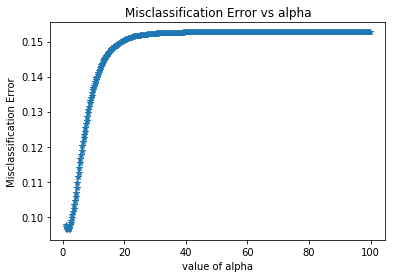


Details for  Bag of Words Vectorization: MultinomialNB
****************************************************************************************************
Accuracy for NaiveBayes algorithm with alpha = 1.7999999999999998  is  90.76
F1 score for NaiveBayes algorithm with alpha = 1.7999999999999998  is  79.9
Recall for NaiveBayes agorithm with alpha = 1.7999999999999998  is  77.06
Precision for NaiveBayes algorithm with aplha = 1.7999999999999998  is  83.94

 Classification report for NaiveBayes algorithm with alpha = 1.7999999999999998  is 
               precision    recall  f1-score   support

   negative       0.75      0.57      0.65     11248
   positive       0.93      0.97      0.95     63752

avg / total       0.90      0.91      0.90     75000



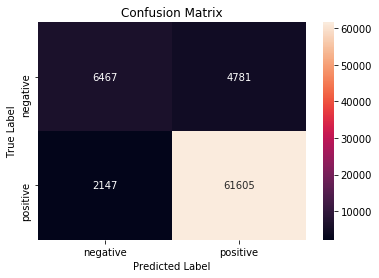

In [73]:
opt_MultinomialNB_bow,opt_alpha_MultinomialNB_bow,pred = Run_MultinomialNB(X_train_bow,Y_train,x_test_bow,y_test,'Bag of Words')

In [74]:
# Accuracy on train data
train_acc_MultinomialNB_bow = opt_MultinomialNB_bow.score(X_train_bow, Y_train)
print("Train accuracy MultinomialNB", train_acc_MultinomialNB_bow)
# Error on train data
train_err_MultinomialNB_bow = 1-train_acc_MultinomialNB_bow
print("Train Error MultinomialNB %f%%" % (train_err_MultinomialNB_bow))

Train accuracy MultinomialNB 0.9123771428571429
Train Error MultinomialNB 0.087623%


In [76]:
# evaluate accuracy on test data
acc_MultinomialNB_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the MultinomialNB classifier is %f%%' % (acc_MultinomialNB_bow))


The accuracy of the MultinomialNB classifier is 90.762667%


In [77]:
#Feature Importance for BoW

# To get all the features name 

bow_features = bow.get_feature_names()

In [78]:
# log probability of features given a class(i.e. P(x_i|y))

log_prob = opt_MultinomialNB_bow.feature_log_prob_
log_prob

array([[-13.19287569, -12.75104293, -13.19287569, ..., -13.19287569,
        -13.19287569, -13.19287569],
       [-14.3142923 , -13.16916   , -14.3142923 , ..., -14.3142923 ,
        -14.3142923 , -14.3142923 ]])

In [79]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(49540, 2)

# Top 10 feature from both class MultinomialNB BOW

In [80]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -4.618169
like      -4.632644
product   -4.773687
one       -4.961174
would     -5.034932
tri       -5.107697
good      -5.162213
buy       -5.196783
flavor    -5.223326
use       -5.246258
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -4.666001
tast      -4.692817
love      -4.712880
good      -4.728411
great     -4.741623
use       -4.903118
flavor    -4.925632
one       -4.932469
product   -4.981677
tri       -5.006605
Name: 1, dtype: float64



The optimal number of alpha is 1.


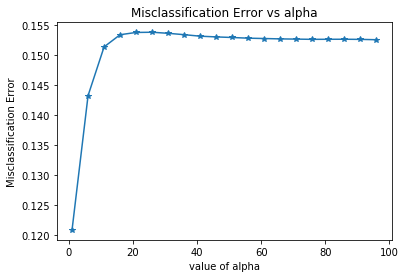


Details for  Bag of Words Vectorization: BernoulliNB
****************************************************************************************************
Accuracy for NaiveBayes algorithm with alpha = 1  is  88.48
F1 score for NaiveBayes algorithm with alpha = 1  is  76.3
Recall for NaiveBayes agorithm with alpha = 1  is  75.09
Precision for NaiveBayes algorithm with aplha = 1  is  77.73

 Classification report for NaiveBayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.63      0.56      0.59     11248
   positive       0.92      0.94      0.93     63752

avg / total       0.88      0.88      0.88     75000



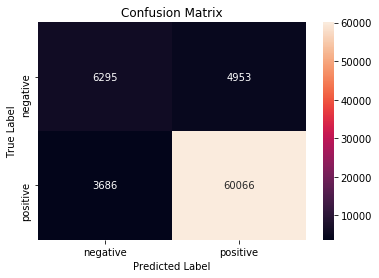

In [126]:
opt_BernoulliNB_bow,opt_alpha_BernoulliNB_bow,pred = Run_BernoulliNB(X_train_bow,Y_train,x_test_bow,y_test,'Bag of Words')

In [127]:
# Accuracy on train data
train_acc_BernoulliNB_bow = opt_BernoulliNB_bow.score(X_train_bow, Y_train)
print("Train accuracy MultinomialNB", train_acc_BernoulliNB_bow)
# Error on train data
train_err_BernoulliNB_bow = 1-train_acc_BernoulliNB_bow
print("Train Error BernoulliNB %f%%" % (train_err_BernoulliNB_bow))

Train accuracy MultinomialNB 0.8901542857142857
Train Error BernoulliNB 0.109846%


In [128]:
# evaluate accuracy on test data
acc_BernoulliNB_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the BernoulliNB classifier is %f%%' % (acc_BernoulliNB_bow))


The accuracy of the BernoulliNB classifier is 88.481333%


In [129]:
# log probability of features given a class(i.e. P(x_i|y))

log_prob = opt_BernoulliNB_bow.feature_log_prob_
log_prob

array([[-10.19163202,  -9.49848484, -10.19163202, ..., -10.19163202,
        -10.19163202, -10.19163202],
       [-11.21401391,  -9.82771955, -11.21401391, ..., -11.21401391,
        -11.21401391, -11.21401391]])

In [130]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(49540, 2)

# Top 10 feature from both class BernoulliNB BOW

In [131]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -1.029222
like      -1.043699
product   -1.184755
one       -1.372262
would     -1.446029
tri       -1.518804
good      -1.573327
buy       -1.607902
flavor    -1.634449
use       -1.657385
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -1.229269
tast      -1.256086
love      -1.276149
good      -1.291680
great     -1.304892
use       -1.466391
flavor    -1.488906
one       -1.495742
product   -1.544952
tri       -1.569880
Name: 1, dtype: float64


# TF-IDF

In [28]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2),binary = True,min_df = 5).fit(X_train)

X_tr_vectorized = tf_idf_vec.transform(X_train)
X_ts_vectorized = tf_idf_vec.transform(x_test)

In [29]:
from sklearn.preprocessing import StandardScaler

X_train_tfidf = StandardScaler(with_mean = False).fit_transform(X_tr_vectorized)

x_test_tfidf = StandardScaler(with_mean = False).fit_transform(X_ts_vectorized)

X_train_tfidf.shape

(175000, 214690)

In [30]:
x_test_tfidf.shape

(75000, 214690)


The optimal number of alpha is 1.


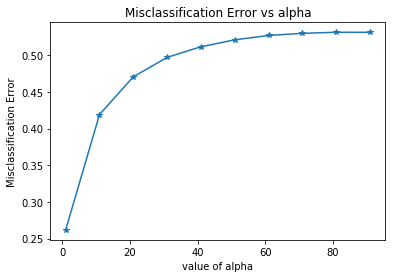


Details for  Tf-Idf Vectorization: MultinomialNB
****************************************************************************************************
Accuracy for NaiveBayes algorithm with alpha = 1  is  87.33
F1 score for NaiveBayes algorithm with alpha = 1  is  69.25
Recall for NaiveBayes agorithm with alpha = 1  is  65.99
Precision for NaiveBayes algorithm with aplha = 1  is  76.71

 Classification report for NaiveBayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.64      0.36      0.46     11248
   positive       0.89      0.96      0.93     63752

avg / total       0.86      0.87      0.86     75000



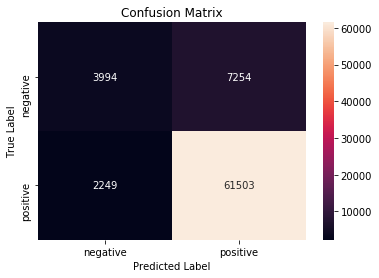

In [103]:
opt_MultinomialNB_tfidf,opt_alpha_MultinomialNB_tfidf,pred = Run_MultinomialNB(X_train_tfidf,Y_train,x_test_tfidf,y_test,'Tf-Idf')

In [104]:
# Accuracy on train data
train_acc_MultinomialNB_tfidf = opt_MultinomialNB_tfidf.score(X_train_tfidf, Y_train)
print("Train accuracy MultinomialNB", train_acc_MultinomialNB_tfidf)
# Error on train data
train_err_MultinomialNB_tfidf = 1-train_acc_MultinomialNB_tfidf
print("Train Error MultinomialNB %f%%" % (train_err_MultinomialNB_tfidf))

Train accuracy MultinomialNB 0.9986285714285714
Train Error MultinomialNB 0.001371%


In [105]:
# evaluate accuracy
acc_MultinomialNB_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the MultinomialNB classifier %f%%' % ( acc_MultinomialNB_tfidf))


The accuracy of the MultinomialNB classifier 87.329333%


In [38]:
#Feature Importance for Tf-Idf

# To get all the features name 

tfidf_features = tf_idf_vec.get_feature_names()

In [107]:
# log probability of features given a class(i.e. P(x_i|y))

log_prob = opt_MultinomialNB_tfidf.feature_log_prob_
log_prob

array([[-19.10432833, -19.10432833, -14.9542302 , ..., -19.10432833,
        -19.10432833, -19.10432833],
       [-14.58449859, -14.58449859, -13.90962735, ..., -14.58449859,
        -14.58449859, -14.58449859]])

In [108]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(1804858, 2)

# Top 10 feature from both class MultinomialNB TfIdf

In [109]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast         -9.235185
like         -9.341856
product      -9.398727
disappoint   -9.418171
would        -9.456270
one          -9.596646
bad          -9.611817
return       -9.637530
dont         -9.682357
wast         -9.683024
Name: 0, dtype: float64


 Top 10 Positive Features:-
 love     -9.306467
great    -9.326125
like     -9.345187
good     -9.345870
tast     -9.369360
use      -9.449007
flavor   -9.486851
one      -9.493188
tri      -9.520469
make     -9.541739
Name: 1, dtype: float64



The optimal number of alpha is 1.


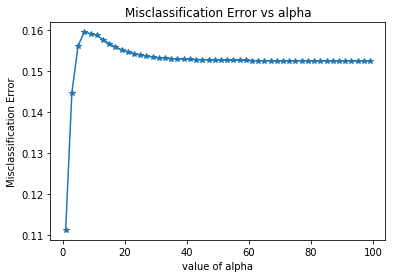


Details for  Tf-Idf Vectorization: BernoulliNB
****************************************************************************************************
Accuracy for NaiveBayes algorithm with alpha = 1  is  89.72
F1 score for NaiveBayes algorithm with alpha = 1  is  79.57
Recall for NaiveBayes agorithm with alpha = 1  is  79.19
Precision for NaiveBayes algorithm with aplha = 1  is  79.97

 Classification report for NaiveBayes algorithm with alpha = 1  is 
               precision    recall  f1-score   support

   negative       0.66      0.64      0.65     11248
   positive       0.94      0.94      0.94     63752

avg / total       0.90      0.90      0.90     75000



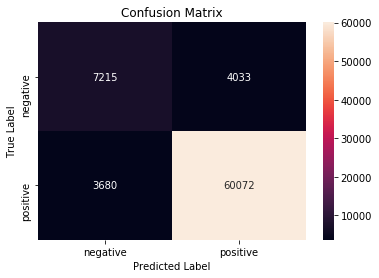

In [32]:
opt_BernoulliNB_tfidf,opt_alpha_BernoulliNB_tfidf,pred = Run_BernoulliNB(X_train_tfidf,Y_train,x_test_tfidf,y_test,'Tf-Idf')

In [33]:
# Accuracy on train data
train_acc_BernoulliNB_tfidf = opt_BernoulliNB_tfidf.score(X_train_tfidf, Y_train)
print("Train accuracy BernoulliNB", train_acc_BernoulliNB_tfidf)
# Error on train data
train_err_BernoulliNB_tfidf = 1-train_acc_BernoulliNB_tfidf
print("Train Error BernoulliNB %f%%" % (train_err_BernoulliNB_tfidf))

Train accuracy BernoulliNB 0.9179885714285714
Train Error BernoulliNB 0.082011%


In [35]:
# evaluate accuracy
acc_BernoulliNB_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the BernoulliNB classifier %f%%' % ( acc_BernoulliNB_tfidf))


The accuracy of the BernoulliNB classifier 89.716000%


In [36]:
# log probability of features given a class(i.e. P(x_i|y))

log_prob = opt_BernoulliNB_tfidf.feature_log_prob_
log_prob

array([[ -9.49848484, -10.19163202, -10.19163202, ...,  -9.49848484,
         -9.49848484,  -9.09301973],
       [ -9.82771955,  -9.96125094, -10.11540162, ...,  -9.96125094,
        -10.29772318, -10.52086673]])

In [39]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(214690, 2)

# Top 10 feature from both class BernoulliNB TfIdf

In [40]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 tast      -1.029222
like      -1.043699
product   -1.184755
one       -1.372262
would     -1.446029
tri       -1.518804
good      -1.573327
buy       -1.607902
flavor    -1.634449
use       -1.657385
Name: 0, dtype: float64


 Top 10 Positive Features:-
 like      -1.229269
tast      -1.256086
love      -1.276149
good      -1.291680
great     -1.304892
use       -1.466391
flavor    -1.488906
one       -1.495742
product   -1.544952
tri       -1.569880
Name: 1, dtype: float64


Conclusion:

1. Optimal alpha value is 1 using MultinomialNB and BernoulliNB for both Bow and tf-idf vectorizers.

2. Accuracy for MultinomialNB is greater than BernoulliNB using Bow but it is opposite for tf-df.

3. For Bow using MultinomialNB we got the higher accuaracy and f1 score.

4. For tf-idf using BernoulliNB we got higher accuracy and f1 score.